In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenCLIPEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from models import *

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device
print("device:",device)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


LOCAL RANK  0
device: cuda


In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # model_name = "final_subj01_pretrained_40sess_24bs"
    model_name = "pretrained_subj01_40sess_hypatia_no_blurry2"
    print("model_name:", model_name)
    mode = "imagery"
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--model_name={model_name} --subj=1 --mode {mode} --no-blurry_recon"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: pretrained_subj01_40sess_hypatia_no_blurry2
--model_name=pretrained_subj01_40sess_hypatia_no_blurry2 --subj=1 --mode imagery --no-blurry_recon


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8,9,10,11],
    help="Evaluate on which subject?",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--mode",type=str,default="vision",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

if mode == "synthetic":
    _, all_images = utils.load_nsd_synthetic(subject=subj, average=False, nest=True)
elif subj > 8:
    _, _, _, all_images = utils.load_imageryrf(subject=subj-8, mode=mode, stimtype="object", average=False, nest=True, split=True)
    figure_dims = (16,8)
else:
    _, all_images = utils.load_nsd_mental_imagery(subject=subj, mode=mode, stimtype="all", average=False, nest=True)
    figure_dims = (6,6)

all_recons = torch.load(f"evals/{model_name}/{model_name}_all_recons_{mode}.pt")
all_clipvoxels = torch.load(f"evals/{model_name}/{model_name}_all_clipvoxels_{mode}.pt")
if blurry_recon:
    all_blurryrecons = torch.load(f"evals/{model_name}/{model_name}_all_blurryrecons_{mode}.pt")
    all_blurryrecons = transforms.Resize((768,768))(all_blurryrecons).float()
all_predcaptions = torch.load(f"evals/{model_name}/{model_name}_all_predcaptions_{mode}.pt")

all_recons = transforms.Resize((768,768))(all_recons).float()

print(model_name)
print(all_images.shape, all_recons.shape, all_clipvoxels.shape, all_predcaptions.shape)

pretrained_subj01_40sess_hypatia_no_blurry2
torch.Size([18, 3, 425, 425]) torch.Size([18, 3, 768, 768]) torch.Size([18, 256, 1664]) (18,)


/export/raid1/home/kneel027/miniconda3/envs/mindeye_imagery/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
sampler_config = unclip_params["sampler_config"]
sampler_config['params']['num_steps'] = 38
config = OmegaConf.load("generative_models/configs/inference/sd_xl_base.yaml")
config = OmegaConf.to_container(config, resolve=True)
refiner_params = config["model"]["params"]

network_config = refiner_params["network_config"]
denoiser_config = refiner_params["denoiser_config"]
first_stage_config = refiner_params["first_stage_config"]
conditioner_config = refiner_params["conditioner_config"]
scale_factor = refiner_params["scale_factor"]
disable_first_stage_autocast = refiner_params["disable_first_stage_autocast"]

# base_ckpt_path = '/weka/robin/projects/stable-research/checkpoints/sd_xl_base_1.0.safetensors'
base_ckpt_path = '../cache/zavychromaxl_v30.safetensors'
base_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config, # using the one defined by the unclip
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast,
                       ckpt_path=base_ckpt_path)
base_engine.eval().requires_grad_(False)
base_engine.to(device)

base_text_embedder1 = FrozenCLIPEmbedder(
    layer=conditioner_config['params']['emb_models'][0]['params']['layer'],
    layer_idx=conditioner_config['params']['emb_models'][0]['params']['layer_idx'],
)
base_text_embedder1.to(device)

base_text_embedder2 = FrozenOpenCLIPEmbedder2(
    arch=conditioner_config['params']['emb_models'][1]['params']['arch'],
    version=conditioner_config['params']['emb_models'][1]['params']['version'],
    freeze=conditioner_config['params']['emb_models'][1]['params']['freeze'],
    layer=conditioner_config['params']['emb_models'][1]['params']['layer'],
    always_return_pooled=conditioner_config['params']['emb_models'][1]['params']['always_return_pooled'],
    legacy=conditioner_config['params']['emb_models'][1]['params']['legacy'],
)
base_text_embedder2.to(device)

batch={"txt": "",
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device),
      "target_size_as_tuple": torch.ones(1, 2).to(device) * 1024}
out = base_engine.conditioner(batch)
crossattn = out["crossattn"].to(device)
vector_suffix = out["vector"][:,-1536:].to(device)
print("crossattn", crossattn.shape)
print("vector_suffix", vector_suffix.shape)
print("---")

batch_uc={"txt": "painting, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, deformed, ugly, blurry, bad anatomy, bad proportions, extra limbs, cloned face, skinny, glitchy, double torso, extra arms, extra hands, mangled fingers, missing lips, ugly face, distorted face, extra legs, anime",
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device),
      "target_size_as_tuple": torch.ones(1, 2).to(device) * 1024}
out = base_engine.conditioner(batch_uc)
crossattn_uc = out["crossattn"].to(device)
vector_uc = out["vector"].to(device)
print("crossattn_uc", crossattn_uc.shape)
print("vector_uc", vector_uc.shape)

SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 10. Setti

Initialized embedder #0: FrozenCLIPEmbedder with 123060480 params. Trainable: False
Initialized embedder #1: FrozenOpenCLIPEmbedder2 with 694659841 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
Restored from ../cache/zavychromaxl_v30.safetensors with 1 missing and 1 unexpected keys
Missing Keys: ['denoiser.sigmas']
Unexpected Keys: ['conditioner.embedders.0.transformer.text_model.embeddings.position_ids']
crossattn torch.Size([1, 77, 2048])
vector_suffix torch.Size([1, 1536])
---
crossattn_uc torch.Size([1, 77, 2048])
vector_uc torch.Size([1, 2816])


In [5]:
plotting=False

num_samples = 1 # PS: I tried increasing this to 16 and picking highest cosine similarity, it didnt seem to increase eval performance!
img2img_timepoint = 13 # 9 # higher number means more reliance on prompt, less reliance on matching the conditioning image
base_engine.sampler.guider.scale = 5 # 5 # cfg
def denoiser(x, sigma, c): return base_engine.denoiser(base_engine.model, x, sigma, c)

if plotting or num_samples>1:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)

In [6]:
all_enhancedrecons = None
for img_idx in tqdm(range(len(all_recons))):
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16), base_engine.ema_scope():
        base_engine.sampler.num_steps = 25
        
        image = all_recons[[img_idx]]
        
        if plotting:
            if blurry_recon:
                print("blur pixcorr:",utils.pixcorr(all_blurryrecons[[img_idx]].float(), all_images[[img_idx]].float()))
                print("blur cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(all_blurryrecons[[img_idx]].float(),256).to(device)).flatten(1), 
                                                            clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(device)).flatten(1)))

            print("recon pixcorr:",utils.pixcorr(image,all_images[[img_idx]].float()))
            print("recon cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(image,224).to(device)).flatten(1), 
                                                         clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(device)).flatten(1)))
        
        image = image.to(device)
        prompt = all_predcaptions[[img_idx]][0]
        # prompt = ""
        if plotting: 
            print("prompt:",prompt)
            if blurry_recon:
                plt.imshow(transforms.ToPILImage()(all_blurryrecons[img_idx].float()))
                plt.show()
            plt.imshow(transforms.ToPILImage()(all_recons[img_idx].float()))
            plt.show()
            plt.imshow(transforms.ToPILImage()(image[0]))
            plt.show()

        # z = torch.randn(num_samples,4,96,96).to(device)
        assert image.shape[-1]==768
        z = base_engine.encode_first_stage(image*2-1).repeat(num_samples,1,1,1)

        openai_clip_text = base_text_embedder1(prompt)
        clip_text_tokenized, clip_text_emb  = base_text_embedder2(prompt)
        clip_text_emb = torch.hstack((clip_text_emb, vector_suffix))
        clip_text_tokenized = torch.cat((openai_clip_text, clip_text_tokenized),dim=-1)
        c = {"crossattn": clip_text_tokenized.repeat(num_samples,1,1), "vector": clip_text_emb.repeat(num_samples,1)}
        uc = {"crossattn": crossattn_uc.repeat(num_samples,1,1), "vector": vector_uc.repeat(num_samples,1)}

        noise = torch.randn_like(z)
        sigmas = base_engine.sampler.discretization(base_engine.sampler.num_steps).to(device)
        init_z = (z + noise * append_dims(sigmas[-img2img_timepoint], z.ndim)) / torch.sqrt(1.0 + sigmas[0] ** 2.0)
        sigmas = sigmas[-img2img_timepoint:].repeat(num_samples,1)

        base_engine.sampler.num_steps = sigmas.shape[-1] - 1
        noised_z, _, _, _, c, uc = base_engine.sampler.prepare_sampling_loop(init_z, cond=c, uc=uc, 
                                                            num_steps=base_engine.sampler.num_steps)
        for timestep in range(base_engine.sampler.num_steps):
            noised_z = base_engine.sampler.sampler_step(sigmas[:,timestep],
                                                        sigmas[:,timestep+1],
                                                        denoiser, noised_z, cond=c, uc=uc, gamma=0)
        samples_z_base = noised_z
        samples_x = base_engine.decode_first_stage(samples_z_base)
        samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)

        # find best sample
        if plotting==False and num_samples==1:
            samples = samples[0]
        else:
            sample_cossim = nn.functional.cosine_similarity(clip_img_embedder(utils.resize(samples,224).to(device)).flatten(1), 
                                clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(device)).flatten(1))
            which_sample = torch.argmax(sample_cossim)
            best_cossim = torch.max(sample_cossim)

            if plotting:
                print("samples", samples.shape)
                for n in range(num_samples):
                    recon = transforms.ToPILImage()(samples[n])
                    plt.imshow(recon)
                    plt.show()
                    if (n==which_sample).item(): print("CHOSEN ABOVE")
                    print("upsampled pixcorr:",utils.pixcorr(samples[[n]].cpu(),all_images[[img_idx]].float()))
                    print("upsampled cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(samples[[n]],224).to(device)).flatten(1), 
                                                         clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(device)).flatten(1)))
                err

            samples = samples[which_sample]

        samples = samples.cpu()[None]
        if all_enhancedrecons is None:
            all_enhancedrecons = samples
        else:
            all_enhancedrecons = torch.vstack((all_enhancedrecons, samples))
            
all_enhancedrecons = transforms.Resize((256,256))(all_enhancedrecons).float()
print("all_enhancedrecons", all_enhancedrecons.shape)
torch.save(all_enhancedrecons,f"evals/{model_name}/{model_name}_all_enhancedrecons_{mode}.pt")
print(f"saved evals/{model_name}/{model_name}_all_enhancedrecons_{mode}.pt")

  0%|          | 0/18 [00:00<?, ?it/s]

/export/raid1/home/kneel027/miniconda3/envs/mindeye_imagery/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/export/raid1/home/kneel027/miniconda3/envs/mindeye_imagery/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 18/18 [00:35<00:00,  1.95s/it]

all_enhancedrecons torch.Size([18, 3, 256, 256])
saved evals/pretrained_subj01_40sess_hypatia_no_blurry2/pretrained_subj01_40sess_hypatia_no_blurry2_all_enhancedrecons_imagery.pt



/export/raid1/home/kneel027/miniconda3/envs/mindeye_imagery/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


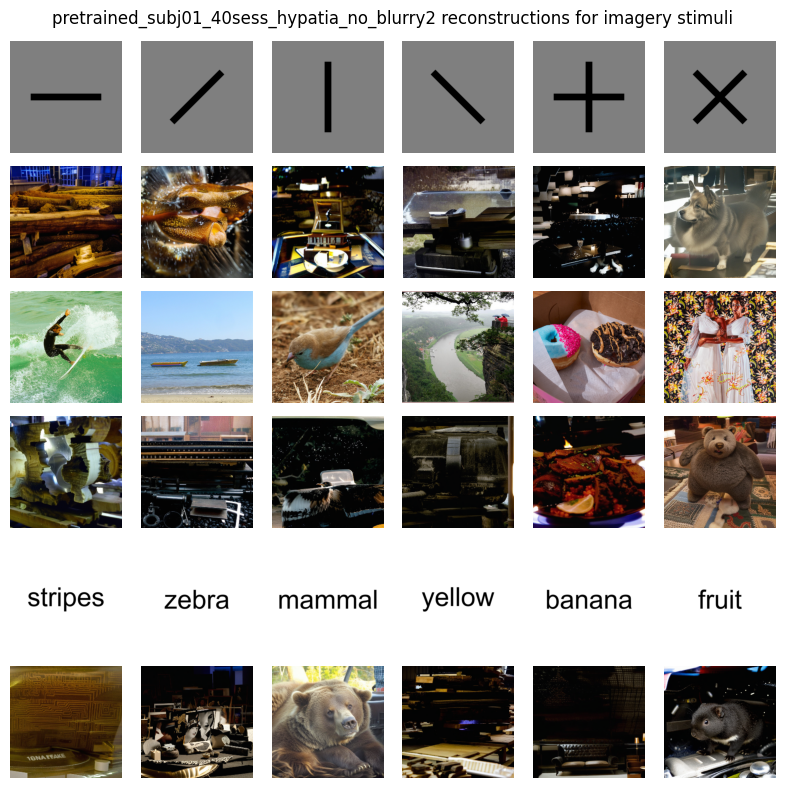

<Figure size 640x480 with 0 Axes>

In [10]:
imsize = 150
if all_images.shape[-1] != imsize:
    all_images = transforms.Resize((imsize,imsize))(transforms.CenterCrop(all_images.shape[2])(all_images)).float()
all_recons = all_enhancedrecons
if all_recons.shape[-1] != imsize:
    all_recons = transforms.Resize((imsize,imsize))(transforms.CenterCrop(all_images.shape[2])(all_recons)).float()

num_images = all_recons.shape[0]
num_rows = (2 * num_images + 11) // 12

# Interleave tensors
merged = torch.stack([val for pair in zip(all_images, all_recons) for val in pair], dim=0)

# Calculate grid size
grid = torch.zeros((num_rows * 12, 3, all_recons.shape[-1], all_recons.shape[-1]))

# Populate the grid
grid[:2*num_images] = merged
grid_images = [transforms.functional.to_pil_image(grid[i]) for i in range(num_rows * 12)]

# Create the grid image
grid_image = Image.new('RGB', (all_recons.shape[-1]*12, all_recons.shape[-1] * num_rows))  # 10 images wide

# Paste images into the grid
for i, img in enumerate(grid_images):
    grid_image.paste(img, (all_recons.shape[-1] * (i % 12), all_recons.shape[-1] * (i // 12)))

grid_image.save(f"../figs/{model_name}_{len(all_recons)}recons_{mode}.png")
print(f"saved ../figs/{model_name}_{len(all_recons)}recons_{mode}.png")

In [ ]:
if not utils.is_interactive():
    sys.exit(0)